Text(0, 0.5, 'x2')

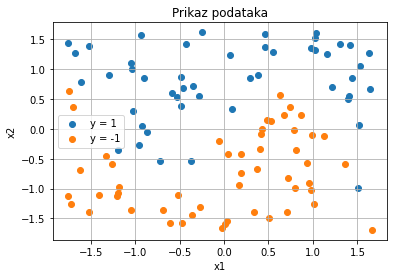

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cvxopt import matrix, solvers
from sklearn.metrics import confusion_matrix
solvers.options['show_progress'] = False

# ucitavanje podataka
data = pd.read_csv('/content/drive/MyDrive/svmData_nls.csv', header=None)
data = data.values

# standardizacija parametara
mean = np.mean(data[:,0:2],axis=0)
std = np.std(data[:,0:2],axis=0)
for i in range(0,len(mean)):
  data[:,i] = (data[:,i]-mean[i])/std[i]


plt.scatter(data[data[:,2] == 1][:,0],data[data[:,2] == 1][:,1])
plt.scatter(data[data[:,2] == -1][:,0],data[data[:,2] == -1][:,1])
plt.title('Prikaz podataka')
plt.legend(['y = 1','y = -1'])
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')

In [2]:
def K(x1,x2,sigma):
  mod = x1 - x2
  mod = mod[0]**2+mod[1]**2
  return np.exp(mod/2/(sigma**2)*(-1))

In [3]:
# klase koje nisu linearno separabilne 
def SVM_nlin(data,sigma,C='inf'):

  m = len(data)
  P = np.zeros([m,m])
  for i in range(m):
    for j in range(m):
      P[i,j] = data[i,2]*data[j,2]*K(data[i,:2],data[j,:2],sigma)
  P = matrix(P)

  q = np.ones([m,1])*(-1)
  q = matrix(q)

  if (C=='inf'):
    G = np.diag(np.ones(m))*(-1)
    G = matrix(G)
    h = np.zeros([m,1])
    h = matrix(h)
  else:
    G = np.append(np.diag(np.ones(m)*(-1)),np.diag(np.ones(m)),axis=0)
    G = matrix(G)
    h = np.append(np.zeros([m,1]),C*np.ones([m,1]))
    h = matrix(h)

  A = np.zeros([1,m]) 
  for i in range(m):
    A[0,i] = data[i,2]
  A = matrix(A)

  b = 0.0
  b = matrix(b)

  alpha = np.array(solvers.qp(P,q,G,h,A,b)['x'])

  noseci_vektori = []
  a = []
  b = 0
  for i in range(0,m):
    if (alpha[i]>0.001):
      noseci_vektori = np.append(noseci_vektori,data[i,:])
      a = np.append(a,alpha[i])
  noseci_vektori = noseci_vektori.reshape(int(len(noseci_vektori)/3),3)
  for i in range(0,m):
    b = b - alpha[i]*data[i,2]*K(data[i,:2],noseci_vektori[1,:2],sigma)

  y_pred = np.zeros(m)
  for i in range(0,m):
    y_pred[i] = np.sign(b+sum((alpha.T*data[:,2]).T*P[:,i]))

  return y_pred,a,b,noseci_vektori

In [4]:
def plot_nonlinear_results(data,alpha,b,noseci_vektori,sigma,title='SVM'):
  plt.scatter(data[data[:,2] == 1][:,0],data[data[:,2] == 1][:,1])
  plt.scatter(data[data[:,2] == -1][:,0],data[data[:,2] == -1][:,1])
  xmin, xmax, ymin, ymax = plt.axis()
  x1, x2 = np.meshgrid(np.linspace(xmin, xmax, num=100, endpoint=True), 
  np.linspace(ymin, ymax, num=100, endpoint=True))
  x_shape = x1.shape
  x1 = x1.ravel()
  x2 = x2.ravel()
  z = np.zeros(len(x1))
  for i in range(0,len(z)):
    for k in range(0,len(alpha)):
      z[i] = z[i] + noseci_vektori[k,2]*alpha[k]*K(noseci_vektori[k,:2],[x1[i],x2[i]],sigma)
    z[i] = np.sign(b + z[i])
  z = z.reshape(x_shape)
  x1 = x1.reshape(x_shape)
  x2 = x2.reshape(x_shape)
  cs = plt.contourf(x1, x2, z, alpha=0.2, cmap='bwr')
  plt.scatter(noseci_vektori[:, 0],noseci_vektori[:, 1], 
        s=100, marker='p', facecolors='none', edgecolor='green', linewidth=2)
  plt.title(title)
  plt.grid()
  plt.xlabel('x1')
  plt.ylabel('x2')


array([[52,  0],
       [ 0, 48]])

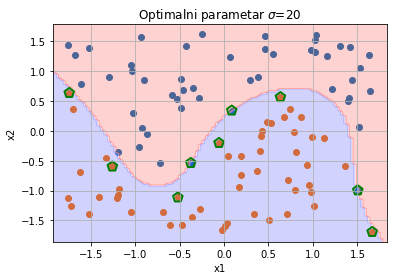

In [5]:
sigma = 20
y_pred,alpha,b,noseci_vektori = SVM_nlin(data,sigma)
plot_nonlinear_results(data,alpha,b,noseci_vektori,sigma,'Optimalni parametar $\u03C3$='+str(sigma))
confusion_matrix(data[:,2],y_pred)

Text(0, 0.5, 'funkcija gubitka')

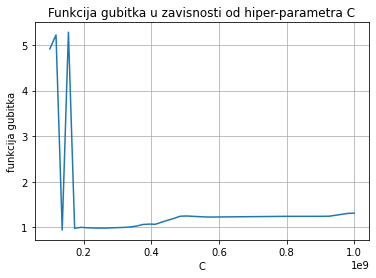

In [22]:
# linearno separabilne klase sa sarkom
C = np.array(np.linspace(10**8,10**9,50))
gama = []
k = 5
foldovi = np.reshape(data,[k,round(len(data)/k),3])

for i in range(0,len(C)): # petlja po tau
  pom = []
  for j in range(0,k): # petlja po foldovima
    prazan_obucavajuci = 1
    for l in range(0,k): # raspodjela foldova u testirajuci i obucavajuce
      if j==l:
        testirajuci = foldovi [j,:,:]
      else:
        if prazan_obucavajuci==1:
          obucavajuci = foldovi[l,:,:]
          prazan_obucavajuci = 0
        else:
          obucavajuci = np.concatenate((obucavajuci,foldovi[l,:,:]),axis=0) 
    y_pred,alpha,b,noseci_vektori = SVM_nlin(obucavajuci,sigma,C[i])
    loss_function = []
    for ii in range(0,len(testirajuci)):
      pom = 0
      for l in range(0,len(noseci_vektori)):
        pom = pom + alpha[l]*noseci_vektori[l,2]*K(noseci_vektori[l,:2],testirajuci[ii,:2],sigma)
      pom = pom +b
      loss_function = np.append(loss_function,1-testirajuci[ii,2]*pom)
    loss_function = sum(loss_function[loss_function>0])
    pom = np.append(pom,loss_function)
  gama = np.append(gama,sum(pom)/k)

plt.plot(C,gama)
plt.grid()
plt.title('Funkcija gubitka u zavisnosti od hiper-parametra C')
plt.xlabel('C')
plt.ylabel('funkcija gubitka')

array([[52,  0],
       [ 0, 48]])

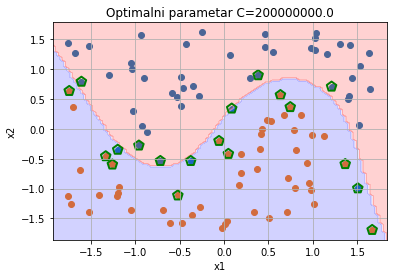

In [21]:
C = 0.2*10**9
y_pred,alpha,b,noseci_vektori = SVM_nlin(data,20,C)
plot_nonlinear_results(data,alpha,b,noseci_vektori,sigma,'Optimalni parametar C='+str(C))
confusion_matrix(data[:,2],y_pred)